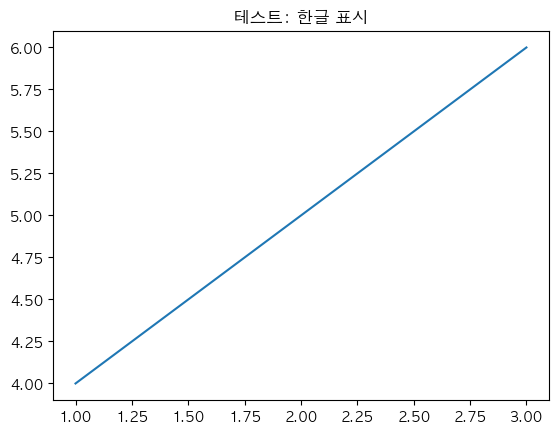

In [176]:
import pandas as pd
from pandasai import SmartDataframe
from pandasai.llm.openai import OpenAI

import numpy as np
import os
import sys
import json
import requests
import gc
from tqdm import tqdm
from datetime import datetime, timedelta
import datetime as dt
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

import statsmodels
import scipy.stats as ss
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

# MacOS에서 한글 폰트 설정
mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 폰트 깨짐 방지

# 테스트 그래프
plt.title('테스트: 한글 표시')
plt.plot([1, 2, 3], [4, 5, 6])
plt.show()
pd.options.display.max_columns = 100
pd.options.display.max_rows=1000


pd.options.display.max_columns = 100
pd.options.display.max_rows=1000


In [175]:
# df = pd.read_csv('../result/result_0403_0509.csv')
df = pd.read_excel('../result/result_0403_0509.xlsx',engine='openpyxl')
df['orderDate'] = pd.to_datetime(df['orderDate'],format='%Y%m%d')
df['click_time'] = df['subParam'].str.split('_').str.get(1)
df['subParam'] = df['subParam'].str.split('_').str.get(0)

## 분석 개요
1. 구매 범위가 너무 넓음. 아웃라이어를 초 VIP 구간으로 넣고, 나머지 평균을 구간화 하기
2. 유저 클릭 시간대 분포와 매출간의 상관성과 분포 보기
3. 유저 아이디 <> MMP 행동 매칭해서, 회귀분석
4. 재방문과 재구매와의 상관관계 보고, uplift 확인하기

## 아웃라이어 처리

In [177]:
# 시간 분포를 위한 로데이터 복제

td = df.query('click_time.notna()')

In [178]:
# 집계 및 아웃라이어 처리
df = df[(df['subParam'].notna()) & (df['subParam']!="0")]
df = df.query("subParam.notna()").groupby('subParam').agg({'total_gmv':'sum','total_commission':'sum','total_quantity':'sum','orderDate':'count'}).reset_index()
df = df[df['total_gmv']>0]

df['zscore'] = ss.zscore(df['total_gmv'])

# zscore > 3 이 일반적이지만, 1로 축소하여 컷. 5% 아웃라이어, 95% 대부분 모수
df['outlier'] = df['zscore'].abs() > 1
print('outlier : ', len(df.query('outlier == True')))
print('outlier ratio : ', len(df.query('outlier == True')) / len(df) )

tt = df.query('outlier == False')
ss = df.query('outlier == True')

outlier :  1413
outlier ratio :  0.054387990762124715


In [181]:
normal = tt.subParam.unique().tolist()
outlier = ss.subParam.unique().tolist()

### 시간 매출 분포

In [207]:

# 유저 아이디가 있는 아웃라이어/정상 유저들로 필터링

tt_tmp = td.query("subParam.isin(@normal)")
ss_tmp = td.query("subParam.isin(@outlier)")

tt_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21735 entries, 51567 to 80217
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         21735 non-null  int64         
 1   orderDate          21735 non-null  datetime64[ns]
 2   trackingCode       21735 non-null  object        
 3   subId              21735 non-null  object        
 4   subParam           21735 non-null  object        
 5   addtag             21735 non-null  int64         
 6   ctag               21735 non-null  object        
 7   orderId            21735 non-null  int64         
 8   productId          21735 non-null  int64         
 9   productName        21735 non-null  object        
 10  quantity           21735 non-null  int64         
 11  gmv                21735 non-null  float64       
 12  commissionRate     21735 non-null  float64       
 13  commission         21735 non-null  int64         
 14  date   

In [ ]:
def get_date(df):
    df['hour_range'] = pd.to_datetime( df['click_time']).dt.floor('H')
    df['hour_range'] = df.hour_range.dt.strftime('%H')

    weekday_list = ['월','화','수','목','금','토','일']

    df['day'] = pd.to_datetime( df['click_time']).dt.weekday
    df['day'] = df.apply(lambda x : weekday_list[x['day']],axis=1)
    
    return df

normal_1 = get_date(tt_tmp)
outlier_1 = get_date(ss_tmp)

그룹바이를 안해서 차트가 이상함. 다시 그룹바이하기

In [210]:
normal_1.groupby()

,Unnamed: 0,orderDate,trackingCode,subId,subParam,addtag,ctag,orderId,productId,productName,quantity,gmv,commissionRate,commission,date,refund_quantity,refund_gmv,refund_commission,total_gmv,total_commission,total_quantity,click_time,hour_range,day
60228,60228,2024-04-26,AF3155932,homecoin,cd7eeedb-f021-4669-be3d-3ffe392012d1,460,5422722958,8314942011342637,6528172171,흙대파,2,2300.0,5.25,121,0,0,0.0,0,2300.0,121,2,20240426005543,00,금
75055,75055,2024-05-06,AF3155932,homecoin,7570e6b9-ae2c-4a44-98f9-ed27190c59cf,460,6714567167,8834949375106530,5158157729,리치팜너트 바나나 칩,3,19920.0,4.50,897,0,0,0.0,0,19920.0,897,3,20240506000002,00,월
59259,59259,2024-04-26,AF3155932,homecoin,cd7eeedb-f021-4669-be3d-3ffe392012d1,460,5422722958,8314942011342637,1407471605,도드람한돈 1등급 뒷다리살 불고기용 (냉장),2,21780.0,5.25,1144,0,0,0.0,0,21780.0,1144,2,20240426005543,00,금
54979,54979,2024-04-23,AF3155932,homecoin,38906983-6421-4b6f-918b-077915bc77f3,460,8020038777,8924943518436810,116251088,스미후루 풍미왕 바나나,1,5030.0,5.25,265,0,0,0.0,0,5030.0,265,1,20240423003833,00,화
54976,54976,2024-04-23,AF3155932,homecoin,38906983-6421-4b6f-918b-077915bc77f3,460,8020038777,8924943518436810,7525033092,맥심 모카골드 마일드 커피믹스,1,7850.0,5.25,413,0,0,0.0,0,7850.0,413,1,20240423003833,00,화
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72356,72356,2024-05-04,AF3155932,homecoin,c3721c6e-d1cd-403e-b0b7-b09b4e3aa2cf,460,7692204239,8684942075655213,5800661748,1+1 심리스 브라런닝 나시 캐미솔 노와이어 캡나시,1,14900.0,4.50,671,0,0,0.0,0,14900.0,671,1,20240503235851,23,금
70420,70420,2024-05-02,AF3155932,homecoin,f85d33e3-6c48-4dbc-aa59-65b80ae4446b,460,5767561086,8054946674202440,6651514859,제이숲 스타일제이 소프트 픽서 볼륨 헤어 스프레이,1,11900.0,5.25,625,0,0,0.0,0,11900.0,625,1,20240430233125,23,화
73308,73308,2024-05-04,AF3155932,homecoin,1c0c8196-c46f-48f3-9166-580e95303de5,400,7227315627,8084945175015067,1942653958,헬로 천연펄프 프라임 코튼 미용티슈 280매,1,11270.0,4.50,508,0,0,0.0,0,11270.0,508,1,20240503231545,23,금
70505,70505,2024-05-02,AF3155932,homecoin,d73e8db4-69da-4881-96c6-8f7d736a8096,400,7253740321,8054946874089795,30853850,페스트세븐 화랑곡나방 퇴치 트랩 플러스,1,12110.0,5.25,636,0,0,0.0,0,12110.0,636,1,20240501235520,23,수


In [186]:
def get_chart_violin(df):
    # 바이올린 차트 그리기
    plt.figure(figsize=(12, 8))
    sns.violinplot(x='day', y='total_gmv', hue='hour_range', data=df, palette='muted', split=True)
    plt.title('day별 시간별 매출 바이올린 차트')
    plt.xlabel('day')
    plt.ylabel('매출액')
    plt.show()


In [192]:
def get_chart_bar(df,col):
    df.sort_values(by='hour_range',ascending=True,inplace=True)
    sns.barplot(data=df, x='hour_range',y=col)

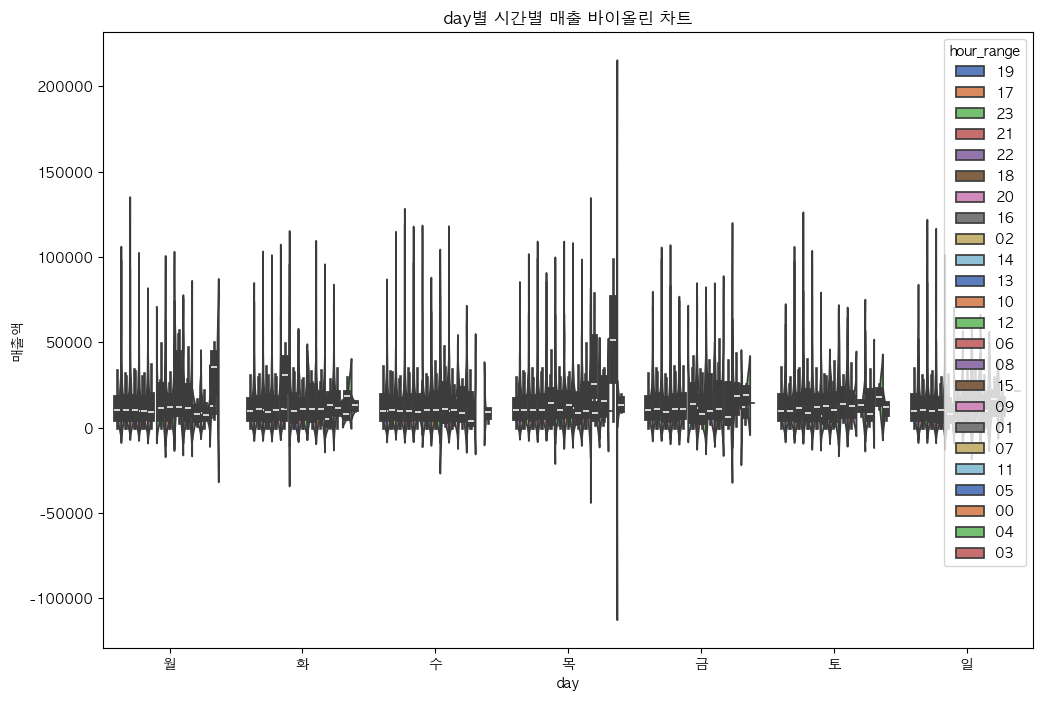

In [190]:
get_chart_violin(normal_1)

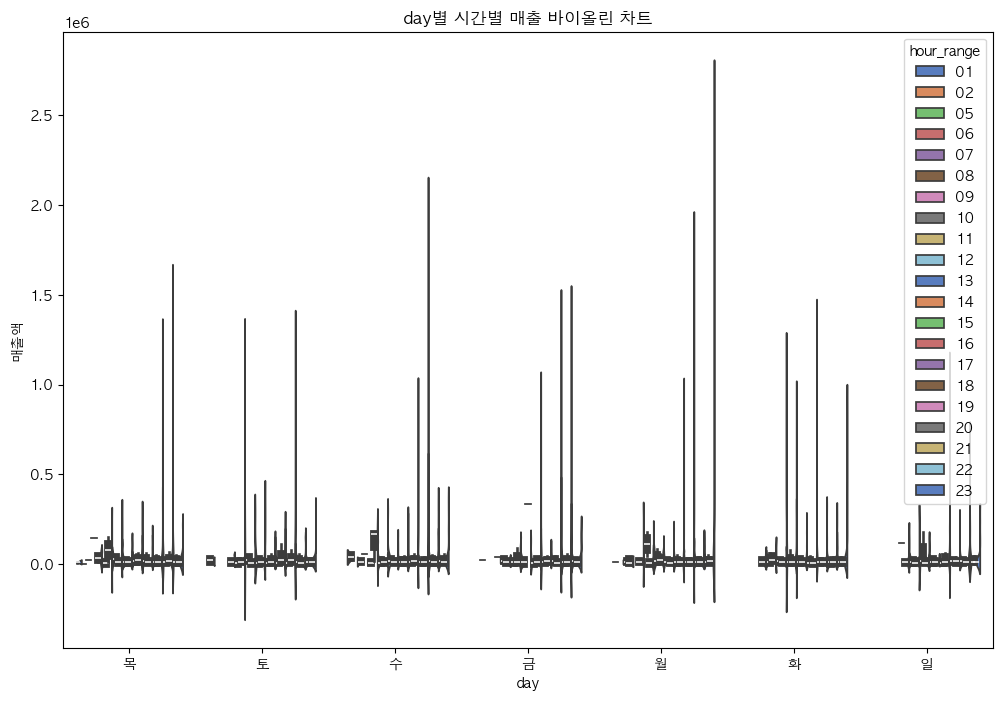

In [198]:
get_chart_violin(outlier_1)

/var/folders/7z/944bgjcs659fsp58nc954qgm0000gn/T/ipykernel_63458/1391250883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by='hour_range',ascending=True,inplace=True)


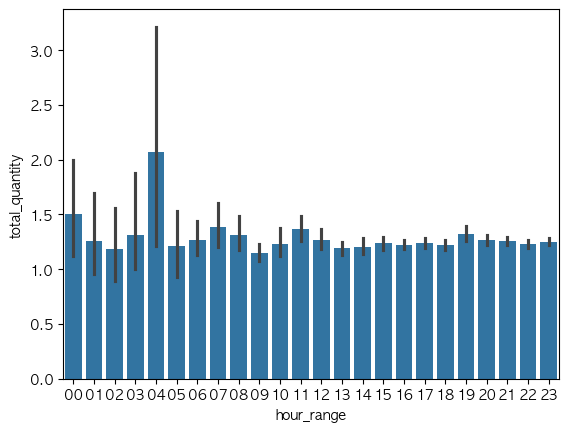

In [199]:
get_chart_bar(normal_1,'total_quantity')

/var/folders/7z/944bgjcs659fsp58nc954qgm0000gn/T/ipykernel_63458/1391250883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by='hour_range',ascending=True,inplace=True)


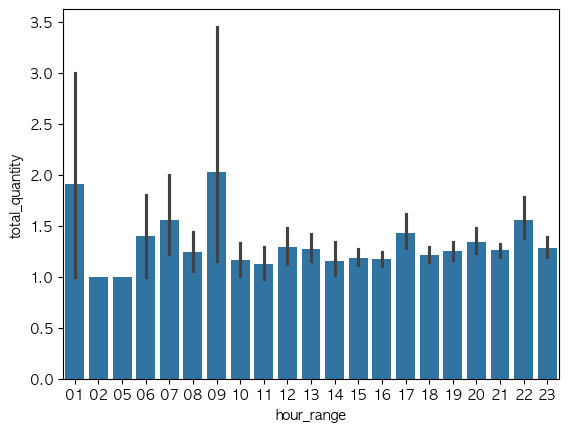

In [197]:

get_chart_bar(outlier_1,'total_quantity')
# normal_1

In [205]:
normal_1.query('hour_range == "04"')
# normal_1['hour_range'].unique()

,Unnamed: 0,orderDate,trackingCode,subId,subParam,addtag,ctag,orderId,productId,productName,quantity,gmv,commissionRate,commission,date,refund_quantity,refund_gmv,refund_commission,total_gmv,total_commission,total_quantity,click_time,hour_range,day
72200,72200,2024-05-04,AF3155932,homecoin,1cc81a19-9596-458c-9aae-27d08834d1b2,460,7838160948,8214940674761623,7183916274,여성용 Sowine 루이 무광 볼륨 벨트,1,10800.0,4.50,486,0,0,0.0,0,10800.0,486,1,20240504040952,04,토
75225,75225,2024-05-06,AF3155932,homecoin,f7fec509-18ab-4a05-a9ab-e14cd30e818e,400,7230559719,8964949075797139,7778832349,오넛티 땅콩버터 오리지널 100%,1,5300.0,4.50,239,0,0,0.0,0,5300.0,239,1,20240506041124,04,월
74870,74870,2024-05-06,AF3155932,homecoin,f7fec509-18ab-4a05-a9ab-e14cd30e818e,400,7230559719,8964949075797139,143226075,쏘피 바디피트 귀애랑 일반 롱 팬티라이너,7,50450.0,4.50,2271,0,0,0.0,0,50450.0,2271,7,20240506041124,04,월
54505,54505,2024-04-23,AF3155932,homecoin,287945f4-152d-496e-bfd8-12dd8c95fe3b,460,7484249970,8964949918491430,58983426,키친아트 라팔 트위니 보온도시락 세트,1,29500.0,5.25,1549,0,0,0.0,0,29500.0,1549,1,20240423040552,04,화
74791,74791,2024-05-06,AF3155932,homecoin,f7fec509-18ab-4a05-a9ab-e14cd30e818e,400,7230559719,8964949075857471,143226075,쏘피 바디피트 귀애랑 일반 롱 팬티라이너,2,35800.0,4.50,1611,0,0,0.0,0,35800.0,1611,2,20240506041124,04,월
57327,57327,2024-04-25,AF3155932,homecoin,b51a795d-8cee-4f0f-9bca-db0759ca4f3e,460,7551684135,8074944411602138,5797059802,아울스 남성용 프리스타일 스포츠 반팔 티 #6628,1,4180.0,5.25,220,0,0,0.0,0,4180.0,220,1,20240425040039,04,목
72741,72741,2024-05-04,AF3155932,homecoin,c9babbca-f0c8-4045-a8d3-2afccd39c7b0,460,327924416,8224942275285098,7851676947,페브리즈 담배냄새제거용 차량용 방향제 블루아이스,6,25800.0,4.50,1161,0,0,0.0,0,25800.0,1161,6,20240503043456,04,금
54509,54509,2024-04-23,AF3155932,homecoin,287945f4-152d-496e-bfd8-12dd8c95fe3b,460,7484249970,8964949918491430,33882872,키친아트 골드메탈 보온죽통 보온도시락 이유식통,1,10800.0,5.25,567,0,0,0.0,0,10800.0,567,1,20240423040552,04,화
75809,75809,2024-05-07,AF3155932,homecoin,c5753737-9947-499d-9df4-f13641adb692,400,7092807652,8074944173089516,5620199346,리브맘 청소기없이 5초 맨손 압축팩,2,20020.0,4.50,901,0,0,0.0,0,20020.0,901,2,20240507040635,04,화
78980,78980,2024-05-09,AF3155932,homecoin,b1158bfa-fbe5-4caf-9472-9432125f64c0,460,7706141860,8814944673638261,7789874399,하루종일 착용해도 편안한 오픈형 블루투스 이어폰 피스넷 사운드핏 / 강력한 통화품질...,1,98900.0,4.50,4451,0,0,0.0,0,98900.0,4451,1,20240509040410,04,목


### 구간화

In [13]:
df = df[(df['subParam'].notna()) & (df['subParam']!="0")]
df = df.query("subParam.notna()").groupby('subParam').agg({'total_gmv':'sum','total_commission':'sum','total_quantity':'sum','orderDate':'count'}).reset_index()
df = df[df['total_gmv']>0]

In [89]:
len(df)

25980

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


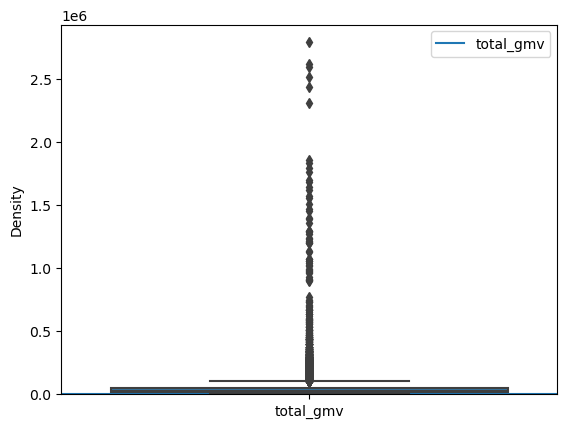

In [90]:
sns.kdeplot(df)
sns.boxplot(df)
plt.show()

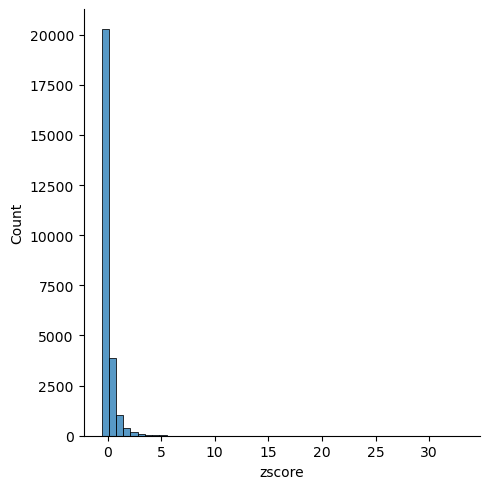

In [20]:
sns.displot(df['zscore'],bins=50)
plt.show()

c:\Users\Owner\miniconda3\envs\pymc\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


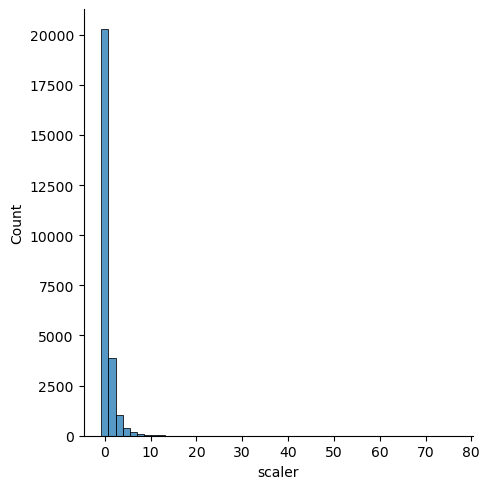

In [115]:
sns.displot(df['scaler'],bins=50)
plt.show()

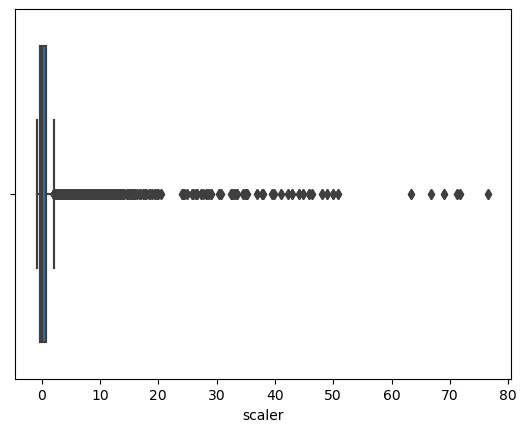

In [118]:
sns.boxplot(x=df['scaler'])
plt.show()

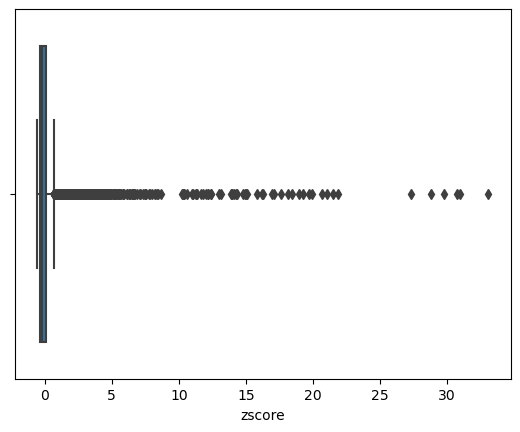

In [119]:
sns.boxplot(x=df['zscore'])
plt.show()

### 아웃라이어 처리가 선행되어야 한다.
- 아웃라이어 처리 (삭제는 안함. 구간을 하나로 묶어버리기)

In [166]:
# zscore > 3 이 일반적이지만, 1로 축소하여 컷. 5% 아웃라이어, 95% 대부분 모수
df['outlier'] = df['zscore'].abs() > 1
print('outlier : ', len(df.query('outlier == True')))
print('outlier ratio : ', len(df.query('outlier == True')) / len(df) )


outlier :  1865
outlier ratio :  0.023249146076940338


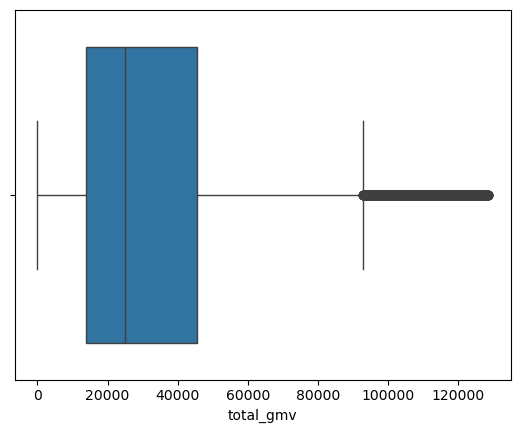

In [100]:
tt = df.query('outlier == False')
ss = df.query('outlier == True')
sns.boxplot(x=tt['total_gmv'])
plt.show()

In [101]:
tt.total_gmv.mean()

33402.39475719461

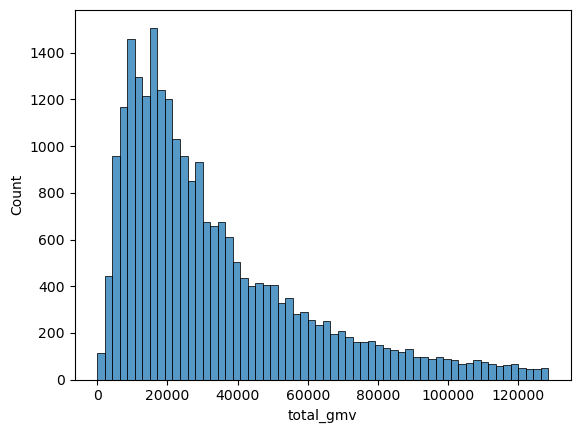

In [102]:
sns.histplot(tt.total_gmv)
plt.show()

[]

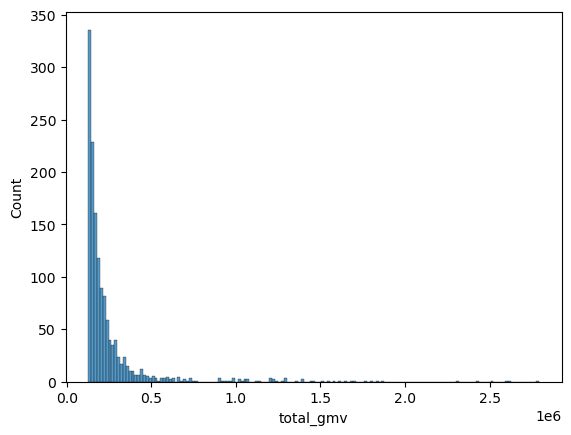

In [107]:
sns.histplot(ss.total_gmv)
plt.plot()

In [105]:
tt.describe()


,total_gmv,total_commission,total_quantity,zscore,scaler
count,24567.000000,24567.000000,24567.000000,24567.000000,24567.000000
mean,33402.394757,1703.890951,3.123865,-0.143629,0.185067
std,26505.515738,1357.572695,3.143596,0.318740,0.733514
min,2.000000,1.000000,0.000000,-0.545283,-0.739256
25%,13970.000000,712.000000,1.000000,-0.377312,-0.352705
50%,24930.000000,1270.000000,2.000000,-0.245513,-0.049398
75%,45500.000000,2309.000000,4.000000,0.001850,0.519856
max,128500.000000,6752.000000,55.000000,0.999959,2.816798


In [106]:
ss.describe()

,total_gmv,total_commission,total_quantity,zscore,scaler
count,1.413000e+03,1413.00000,1413.000000,1413.000000,1413.000000
mean,2.530059e+05,12408.29087,11.843595,2.497195,6.262375
std,2.633939e+05,12391.44933,10.676761,3.167421,7.289162
min,1.285200e+05,3870.00000,1.000000,1.000200,2.817352
25%,1.469500e+05,7483.00000,4.000000,1.221828,3.327383
50%,1.763600e+05,9025.00000,10.000000,1.575496,4.141276
75%,2.427700e+05,12274.00000,17.000000,2.374104,5.979106
max,2.794200e+06,146696.00000,143.000000,33.056114,76.587381


- 구간화
    - 95%, 2만원단위. 5% 초고액

In [113]:
# 구간 범위 설정 (5만원 단위)
bins = np.arange(0, tt['total_gmv'].max() + 20000, 20000)  # 최대값보다 하나 더 많은 구간을 포함하기 위해 추가

# pd.cut을 사용하여 매출 데이터를 구간별로 나누기
labels = [f'{int(i)}원 - {int(j)}원' for i, j in zip(bins[:-1], bins[1:])]  # 레이블 생성
tt['range'] = pd.cut(tt['total_gmv'], bins=bins, labels=labels, right=False)  # 구간 나누기

# 결과 출력
tt


/var/folders/7z/944bgjcs659fsp58nc954qgm0000gn/T/ipykernel_63458/4278965276.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt['range'] = pd.cut(tt['total_gmv'], bins=bins, labels=labels, right=False)  # 구간 나누기


,subParam,total_gmv,total_commission,total_quantity,zscore,scaler,outlier,range
0,00027209-52db-4a23-9918-3163f8484c4a,21570.0,1133,1,-0.285919,-0.142383,False,20000원 - 40000원
1,000518c4-c2c7-45e4-92e0-9cabb94c889b,11800.0,620,1,-0.403407,-0.412758,False,0원 - 20000원
2,000b3874-e05c-4738-9a84-b4d33f90703f,8680.0,456,2,-0.440926,-0.499101,False,0원 - 20000원
3,000c2bc8-d3d6-4f98-b73e-0369cd27641b,90790.0,3766,5,0.546481,1.773212,False,80000원 - 100000원
4,000eac0e-11f4-45f5-95a4-2fe17e4d634e,65640.0,3447,3,0.244042,1.077210,False,60000원 - 80000원
...,...,...,...,...,...,...,...,...
26899,fff35da5-cd77-4eef-a0f9-66f317b1818e,34500.0,1813,3,-0.130430,0.215442,False,20000원 - 40000원
26900,fff389dd-e35f-4c5c-9979-105e15cf0a6e,8910.0,468,1,-0.438160,-0.492736,False,0원 - 20000원
26901,fff79c69-957e-45a8-8100-10085e8322c2,4650.0,245,1,-0.489389,-0.610627,False,0원 - 20000원
26902,fff90531-f4b6-4b14-a128-90fd2a74c4ca,14850.0,669,1,-0.366729,-0.328352,False,0원 - 20000원


/var/folders/7z/944bgjcs659fsp58nc954qgm0000gn/T/ipykernel_63458/3248004894.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tt.groupby('range')['subParam']


### 시간대별 분석 다시